# Football Analysis Notebook

This notebook runs the AI model for football analysis. It includes object detection, keypoint detection, team classification, pitch homography, and video processing. Each section is organized to keep the code clear and maintain the same outputs.

In [ ]:
import numpy as np
print(np.__version__)

In [ ]:
!pip install --force-reinstall --no-cache-dir numpy==1.26.4
!pip install --force-reinstall --no-cache-dir scipy scikit-learn umap-learn gensim
import os
os.kill(os.getpid(), 9)  # Force restart the kernel after pip changes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 289.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
nilearn 0.11.1 requires scikit-learn>=1.4.0, but you have scikit-learn 1.2.2 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.5, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.2 which is incompatible.
dopamine-rl 

In [3]:
# Environment Setup
!nvidia-smi

!pip install -q gdown inference-gpu
!pip install -q git+https://github.com/roboflow/sports.git

# Download sample video
!gdown -O "121364_0.mp4" "https://drive.google.com/uc?id=1vVwjW1dE1drIdd4ZSILfbCGPD4weoNiu"

Tue Apr 29 19:35:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Imports
import os
import io
import sys
import cv2
import umap
import time
import torch
import logging
import contextlib
import numpy as np
import pandas as pd
import supervision as sv

from collections import deque
from inference import get_model
from kaggle_secrets import UserSecretsClient
from google.colab import userdata 
from tqdm import tqdm
from more_itertools import chunked
from sklearn.cluster import KMeans
from typing import List, Union, Optional
from transformers import AutoProcessor, SiglipVisionModel

from sports.common.team import TeamClassifier
from sports.common.view import ViewTransformer
from sports.configs.soccer import SoccerPitchConfiguration
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_paths_on_pitch,
    draw_pitch_voronoi_diagram
)

/usr/local/lib/python3.11/dist-packages/numpy/_core/_dtype.py:106: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if dtype.type == np.bool:


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
# Global Constants and Environment Variables
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"  

SOURCE_VIDEO_PATH = "/kaggle/working/121364_0.mp4"
TARGET_VIDEO_PATH = "/kaggle/working/121364_0_result.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
STRIDE = 30
PLAYER_IN_POSSESSION_PROXIMITY = 40
fps = 25

In [26]:
# Annotators Setup
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

offside_ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#34eb49', '#64f5f0']),
    thickness=2
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

player_triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#072D69'),
    base=20, height=17
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)

offside_label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#34eb49', '#64f5f0']),
    text_color=sv.Color.from_hex('#000000'),
    text_scale=0.2,
    text_thickness=1,
    text_padding=3,
    text_position=sv.Position.BOTTOM_CENTER
)

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8
)

vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8
)

In [5]:
# User Secrets and API Keys
user_secrets = UserSecretsClient()
ROBOFLOW_API_KEY = user_secrets.get_secret("Roboflow")

In [6]:
# Class Definitions

class FrameDetections:
    def __init__(self, frame, detections, tracker, team_classifier, 
                 BALL_ID=0, GOALKEEPER_ID=1, PLAYER_ID=2, REFEREE_ID=3, pad_px=10, nms_threshold=0.5):
        self.frame = frame
        self.detections = detections
        self.tracker = tracker
        self.BALL_ID = BALL_ID
        self.GOALKEEPER_ID = GOALKEEPER_ID
        self.PLAYER_ID = PLAYER_ID
        self.REFEREE_ID = REFEREE_ID
        self.pad_px = pad_px
        self.nms_threshold = nms_threshold
        self.team_classifier = team_classifier
        
        # Process ball detections
        self.ball_detections = self.detections[self.detections.class_id == self.BALL_ID]
        self.ball_detections.xyxy = sv.pad_boxes(xyxy=self.ball_detections.xyxy, px=self.pad_px)
        
        # Process non-ball detections with NMS and tracker update
        self.all_detections = self.detections[self.detections.class_id != self.BALL_ID]
        self.all_detections = self.all_detections.with_nms(threshold=self.nms_threshold, class_agnostic=True)
        self.all_detections = self.tracker.update_with_detections(detections=self.all_detections)
        
        # Separate goalkeepers, players, and referees
        self.goalkeepers_detections = self.all_detections[self.all_detections.class_id == self.GOALKEEPER_ID]
        self.players_detections = self.all_detections[self.all_detections.class_id == self.PLAYER_ID]
        self.referees_detections = self.all_detections[self.all_detections.class_id == self.REFEREE_ID]
        
        # Crop player images and classify team (suppress stderr during prediction)
        players_crops = [sv.crop_image(self.frame, xyxy) for xyxy in self.players_detections.xyxy]
        with contextlib.redirect_stderr(io.StringIO()):
            self.players_detections.class_id = self.team_classifier.predict(players_crops)
        
        # Resolve goalkeeper team ids using player detections
        self.goalkeepers_detections.class_id = self.resolve_goalkeepers_team_id(
            self.players_detections, self.goalkeepers_detections
        )
        
        # Adjust referees class id
        self.referees_detections.class_id -= 1
        
        # Merge detections for annotation
        self.all_detections = sv.Detections.merge([
            self.players_detections, self.goalkeepers_detections, self.referees_detections
        ])
        self.labels = [f"#{tid}" for tid in self.all_detections.tracker_id]
        self.all_detections.class_id = self.all_detections.class_id.astype(int)
        self.all_players_detections = sv.Detections.merge([
            self.players_detections, self.goalkeepers_detections
        ])

    def resolve_goalkeepers_team_id(self, players: sv.Detections, goalkeepers: sv.Detections) -> np.ndarray:
        goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        
        team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
        team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
        
        goalkeepers_team_id = []
        for goalkeeper_xy in goalkeepers_xy:
            dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
            dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
            goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)
    
        return np.array(goalkeepers_team_id)


class PitchDetections:
    def __init__(self, frame, f: FrameDetections, key_points, 
                 BALL_ID=0, GOALKEEPER_ID=1, PLAYER_ID=2, REFEREE_ID=3):
        self.f = f
        self.key_points = key_points
        self.BALL_ID = BALL_ID
        self.GOALKEEPER_ID = GOALKEEPER_ID
        self.PLAYER_ID = PLAYER_ID
        self.REFEREE_ID = REFEREE_ID
        CONFIG = SoccerPitchConfiguration()
        
        # Project key points from frame to pitch
        filter = key_points.confidence[0] > 0.5
        frame_reference_points = key_points.xy[0][filter]
        pitch_reference_points = np.array(CONFIG.vertices)[filter]
    
        self.transformer = ViewTransformer(
            source=frame_reference_points,
            target=pitch_reference_points
        )
        
        self.transformer_inverse = ViewTransformer(
            source=pitch_reference_points,
            target=frame_reference_points
        )
        
        self.frame_ball_xy = f.ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_ball_xy = self.transformer.transform_points(points=self.frame_ball_xy)
        
        self.all_players_xy = f.all_players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_all_players_xy = self.transformer.transform_points(points=self.all_players_xy)

        self.players_xy = f.players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_players_xy = self.transformer.transform_points(points=self.players_xy)
        
        self.referees_xy = f.referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_referees_xy = self.transformer.transform_points(points=self.referees_xy)

        self.team_players_0 = f.players_detections[(f.players_detections.class_id == 0)]
        self.team_players_0_xy = self.team_players_0.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.team_players_1 = f.players_detections[(f.players_detections.class_id == 1)]
        self.team_players_1_xy = self.team_players_1.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
        self.pitch_team0_players_xy = self.transformer.transform_points(points=self.team_players_0_xy)
        self.pitch_team1_players_xy = self.transformer.transform_points(points=self.team_players_1_xy)


## Model Loading

Load Object Detection, Field Detection, and Classification models.

In [7]:
# Load Object Detection Model
DETECTION_MODEL_ID = "football-detection-ysgxf/3"
DETECTION_MODEL = get_model(
    model_id=DETECTION_MODEL_ID, 
    api_key=ROBOFLOW_API_KEY
)

In [8]:
# Load Field (Keypoint) Detection Model
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi-jufj9/1"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

In [9]:
# Load Classification Model (SigLIP)
SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

### Crop Extraction for Classification

Extract player crops from video frames and compute embeddings.

Number of crops: 478


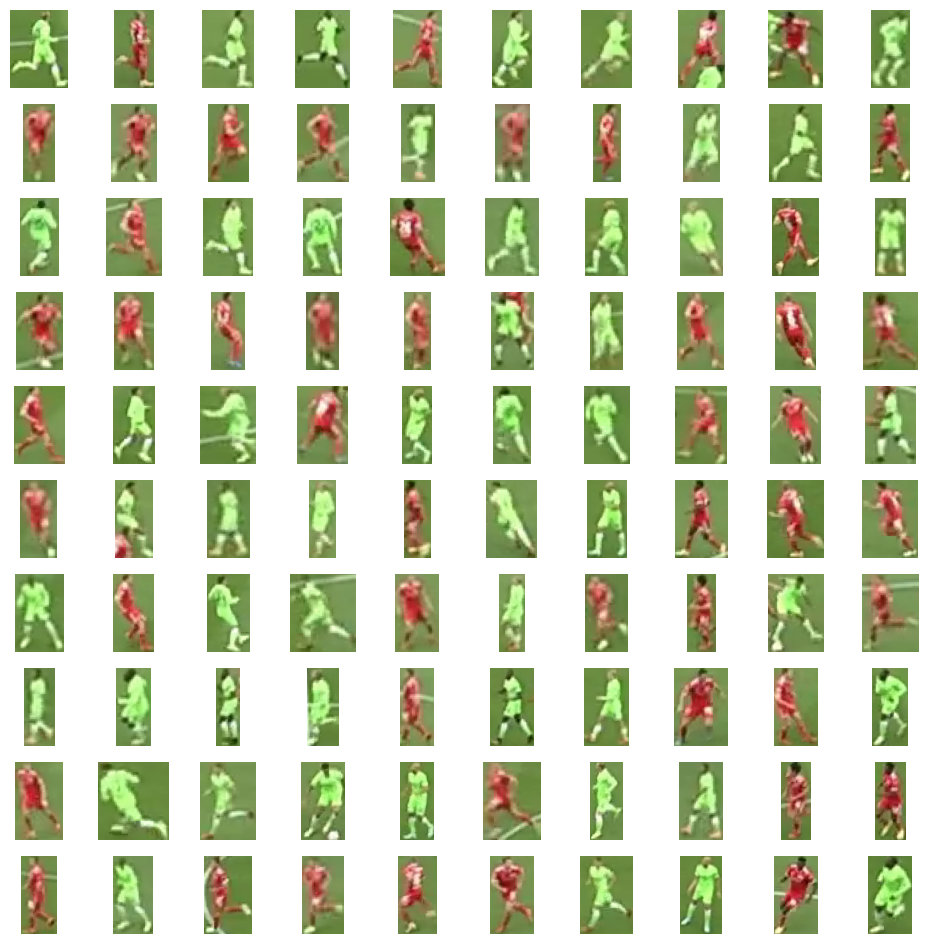

In [10]:
def extract_crops(source_video_path: str):
    # Stride to sample every STRIDE-th frame
    frame_generator = sv.get_video_frames_generator(source_path=source_video_path, stride=STRIDE)
    crops = []
    for frame_sample in tqdm(frame_generator, desc='Collecting crops'):
        result = DETECTION_MODEL.infer(frame_sample, confidence=0.3)[0]
        detections = sv.Detections.from_inference(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [sv.crop_image(frame_sample, xyxy) for xyxy in detections.xyxy]
    return crops

crops = extract_crops(SOURCE_VIDEO_PATH)
print('Number of crops:', len(crops))
sv.plot_images_grid(crops[:100], grid_size=[10,10])

Embedding extraction: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


Embeddings shape: (478, 768)
Projections shape: (478, 3)
Clusters: [1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1
 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0
 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1
 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0
 1 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 1
 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1
 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0
 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 

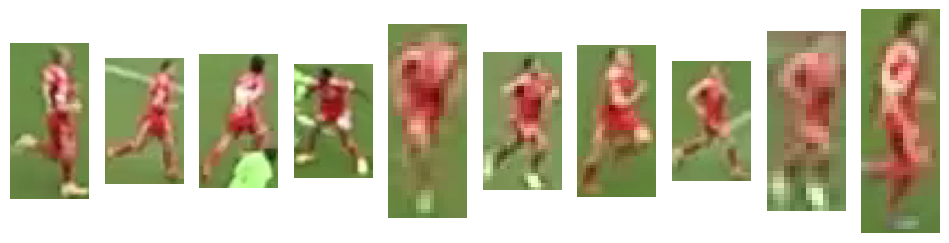

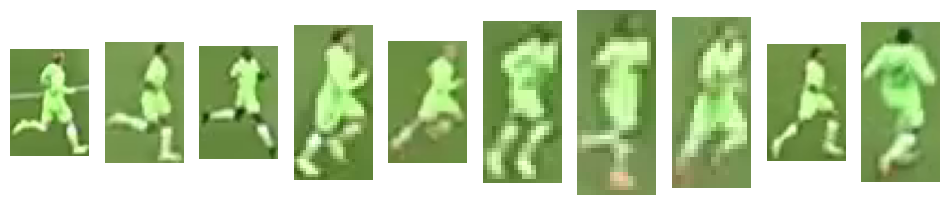

In [11]:
# Convert crops to Pillow images and extract embeddings in batches
BATCH_SIZE = 32
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = list(chunked(crops, BATCH_SIZE))
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='Embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)
print('Embeddings shape:', data.shape)

# Reduce dimensionality and perform clustering
REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)
projections = REDUCER.fit_transform(data)
print('Projections shape:', projections.shape)

clusters = CLUSTERING_MODEL.fit_predict(projections)
print('Clusters:', clusters)

team_0 = [crop for crop, cluster in zip(crops, clusters) if cluster == 0]
team_1 = [crop for crop, cluster in zip(crops, clusters) if cluster == 1]
sv.plot_images_grid(team_0[:10], grid_size=[1,10])
sv.plot_images_grid(team_1[:10], grid_size=[1,10])

In [12]:
# Collect crops for team classification from video frames
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)
crops = []
for frame in tqdm(frame_generator, desc='Collecting crops for team classification'):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

Embedding extraction: 18it [00:04,  3.92it/s]


## Helper Functions for Annotation and Analysis

Functions to determine player possession, offside detection, and frame annotation.

In [35]:
def get_player_in_possession(f: FrameDetections, proximity):
    if len(f.ball_detections) != 1:
        return -1
    ball_centers = f.ball_detections.get_anchors_coordinates(sv.Position.CENTER)
    ball_center = ball_centers[0]
    players_xy = f.players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    min_distance = np.linalg.norm(players_xy[0] - ball_center)
    player = -1
    for player_xy, player_id in zip(players_xy, f.players_detections.tracker_id):
        distance = np.linalg.norm(player_xy - ball_center)
        if distance < min_distance:
            min_distance = distance
            player = player_id
    if min_distance <= proximity:
        return player
    return -1


def find_last_defender(f, p):
    last_defender = {}
    potential_offside = []
    if len(p.pitch_players_xy) > 0:
        if np.mean(p.pitch_team0_players_xy[:, 0]) < np.mean(p.pitch_team1_players_xy[:, 0]):
            last_defender[0] = np.min(p.pitch_team0_players_xy[:, 0])
            last_defender[1] = np.max(p.pitch_team1_players_xy[:, 0])
            for pos, tracker in zip(p.pitch_team0_players_xy, f.players_detections[f.players_detections.class_id == 0].tracker_id):
                if pos[0] > last_defender[1]:
                    potential_offside.append(tracker)
            for pos, tracker in zip(p.pitch_team1_players_xy, f.players_detections[f.players_detections.class_id == 1].tracker_id):
                if pos[0] < last_defender[0]:
                    potential_offside.append(tracker)
        else:
            last_defender[0] = np.max(p.pitch_team0_players_xy[:, 0])
            last_defender[1] = np.min(p.pitch_team1_players_xy[:, 0])
            for pos, tracker in zip(p.pitch_team0_players_xy, f.players_detections[f.players_detections.class_id == 0].tracker_id):
                if pos[0] < last_defender[1]:
                    potential_offside.append(tracker)
            for pos, tracker in zip(p.pitch_team1_players_xy, f.players_detections[f.players_detections.class_id == 1].tracker_id):
                if pos[0] > last_defender[0]:
                    potential_offside.append(tracker)
    else:
        last_defender = None 
    return last_defender, potential_offside


def frame_annotation(frame, f: FrameDetections, previous_possesion=None, offside=False, last_defender_positions=None, potential_offsides=[], cumulative_distances=None, instantaneous_speed=None):
    POSSESION_ID = get_player_in_possession(f, proximity=PLAYER_IN_POSSESSION_PROXIMITY)
    
    if offside:
        if last_defender_positions is None:
            last_defender_positions, potential_offsides = find_last_defender(f, p)
        offside_mask = np.isin(f.all_detections.tracker_id, potential_offsides)
        offside_detections = f.all_detections[offside_mask]
        non_offside_detections = f.all_detections[~offside_mask]
        if cumulative_distances is not None:
            offside_labels = [
                f"#{tid} | {cumulative_distances.get(tid, 0):.2f}m | {instantaneous_speed.get(tid, 0):.2f}km/h"
                for tid in offside_detections.tracker_id
            ]
            non_offside_labels = [
                f"#{tid} | {cumulative_distances.get(tid, 0):.2f}m | {instantaneous_speed.get(tid, 0):.2f}km/h"
                for tid in non_offside_detections.tracker_id
            ]
        else:
            offside_labels = [f"#{tid}" for tid in offside_detections.tracker_id]
            non_offside_labels = [f"#{tid}" for tid in non_offside_detections.tracker_id]
        
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=non_offside_detections)
        annotated_frame = offside_ellipse_annotator.annotate(scene=annotated_frame, detections=offside_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=f.ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=non_offside_detections, labels=non_offside_labels)
        annotated_frame = offside_label_annotator.annotate(scene=annotated_frame, detections=offside_detections, labels=offside_labels)
 
        offside_points = np.array([
            [last_defender_positions[0], 0],
            [last_defender_positions[0], CONFIG.width],
            [last_defender_positions[1], 0],
            [last_defender_positions[1], CONFIG.width]
        ])
        
        frame_coordinates = p.transformer_inverse.transform_points(points=offside_points)
        key_points = sv.KeyPoints(xy=frame_coordinates[np.newaxis, ...])
        
        edges = [(0, 3), (1, 2)]
        edge_annotator = sv.EdgeAnnotator(
            color=sv.Color.from_hex('#00BFFF'),
            thickness=2, 
            edges=edges
        )
        
        annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_points)
        annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=key_points)
    else:
        annotated_frame = frame.copy()
        annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=f.all_detections)
        annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=f.ball_detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=f.all_detections, labels=f.labels)
    
    if POSSESION_ID != -1:
        if len(f.ball_detections) == 0 and previous_possesion is not None:
            possesion_detection = previous_possesion
        else: 
            possesion_detection = f.all_detections[f.all_detections.tracker_id == POSSESION_ID]
            possesion_detection.xyxy = sv.pad_boxes(xyxy=possesion_detection.xyxy, px=10)
            previous_possesion = possesion_detection
        annotated_frame = player_triangle_annotator.annotate(scene=annotated_frame, detections=possesion_detection)
            
    return annotated_frame, previous_possesion


def homography_pitch(frame, f: FrameDetections, p: PitchDetections, offside=False, last_defender_positions=None, potential_offsides=[]):    
    annotated_frame = draw_pitch(CONFIG)
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_ball_xy,
        face_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_all_players_xy[f.all_players_detections.class_id == 0],
        face_color=sv.Color.from_hex('00BFFF'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_all_players_xy[f.all_players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    annotated_frame = draw_points_on_pitch(
        config=CONFIG,
        xy=p.pitch_referees_xy,
        face_color=sv.Color.from_hex('FFD700'),
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=annotated_frame
    )
    if offside:
        if last_defender_positions is None:
            last_defender_positions, potential_offsides = find_last_defender(f, p)
        offside_mask = np.isin(f.all_detections.tracker_id, potential_offsides)
        x_coord = last_defender_positions[0]
        vertical_line_path = np.array([
            [x_coord, 0],
            [x_coord, CONFIG.width]
        ])
        
        annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
        x_coord = last_defender_positions[1]
        
        vertical_line_path = np.array([
            [x_coord, 0],
            [x_coord, CONFIG.width]
        ])
        annotated_frame = draw_paths_on_pitch(config=CONFIG, paths=[vertical_line_path], pitch=annotated_frame)
    return annotated_frame

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
    ) -> np.ndarray:

    if pitch is None:
        pitch = draw_pitch(config=config, padding=padding, scale=scale)

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((scaled_width + 2 * padding, scaled_length + 2 * padding))

    y_coordinates -= padding
    x_coordinates -= padding
    
    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    steepness = 15  # Sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    for c in range(3):
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] + (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

def draw_pitch_heatmap_on_frame(overlay, transformer_inverse, frame, opacity=0.6):
    resized_overlay = cv2.resize(overlay, None, fx=10, fy=10, interpolation=cv2.INTER_LINEAR)
    warped_overlay = transformer_inverse.transform_image(resized_overlay, resolution_wh=(frame.shape[1], frame.shape[0]))
    final_overlay = cv2.addWeighted(warped_overlay, opacity, frame, 1 - opacity, 0)
    return final_overlay

def lighten_color(hex_color, factor=0.3):
    rgb = tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    lighter_rgb = tuple(min(255, int(c + (255 - c) * factor)) for c in rgb)
    return '#{:02x}{:02x}{:02x}'.format(*lighter_rgb)

def compute_voronoi(p):
        annotated_frame = draw_pitch(
        config=CONFIG,
        background_color=sv.Color.WHITE,
        line_color=sv.Color.BLACK
        )
        annotated_frame = draw_pitch_voronoi_diagram_2(
            config=CONFIG,
            team_1_xy=p.pitch_players_xy[f.players_detections.class_id == 0],
            team_2_xy=p.pitch_players_xy[f.players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=p.pitch_ball_xy,
            face_color=sv.Color.WHITE,
            edge_color=sv.Color.WHITE,
            radius=8,
            thickness=1,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=p.pitch_players_xy[f.players_detections.class_id == 0],
            face_color=sv.Color.from_hex('00BFFF'),
            edge_color=sv.Color.WHITE,
            radius=16,
            thickness=1,
            pitch=annotated_frame
        )
        annotated_frame = draw_points_on_pitch(
            config=CONFIG,
            xy=p.pitch_players_xy[f.players_detections.class_id == 1],
        face_color=sv.Color.from_hex('FF1493'),
        edge_color=sv.Color.WHITE,
        radius=16,
        thickness=1,
        pitch=annotated_frame
        )
        return annotated_frame

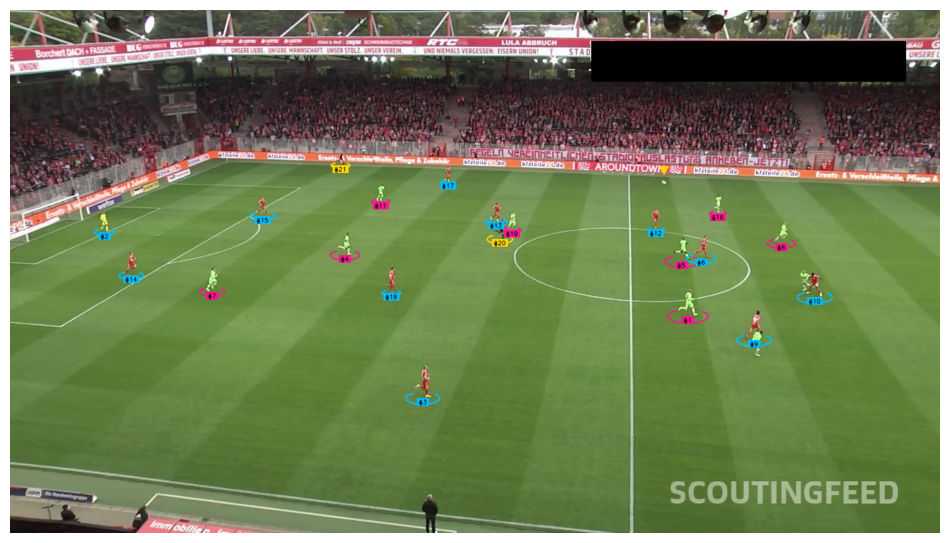

In [24]:
# Process a sample frame for detection and annotation
tracker = sv.ByteTrack()
tracker.reset()

frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))
result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)
f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
output, _ = frame_annotation(frame, f)
sv.plot_image(output)

## Pitch Homography and Field Detection

Detect key points on a frame and draw the pitch with projected points.

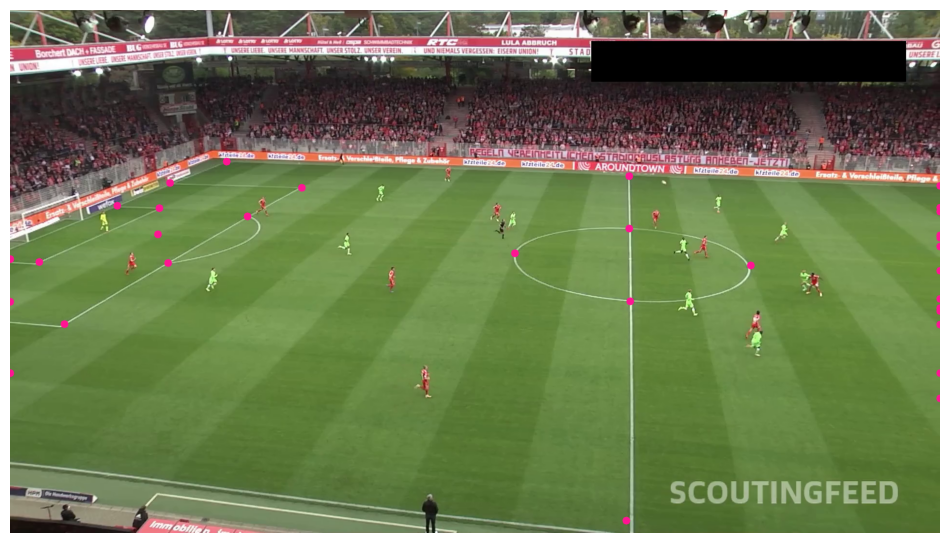

In [15]:
# Detect key points on a sample frame
frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH))
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=key_points)
sv.plot_image(annotated_frame)

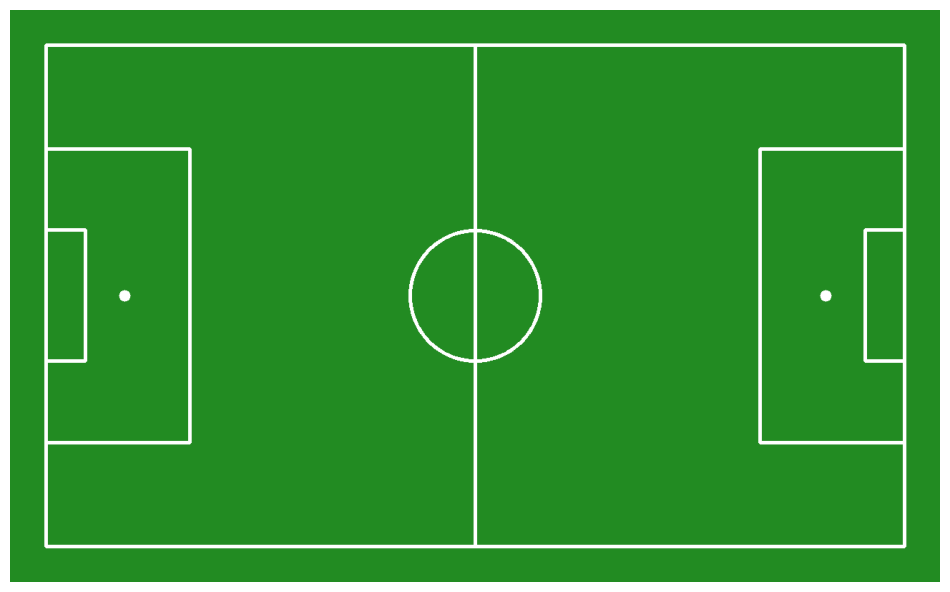

In [16]:
CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)
sv.plot_image(annotated_frame)

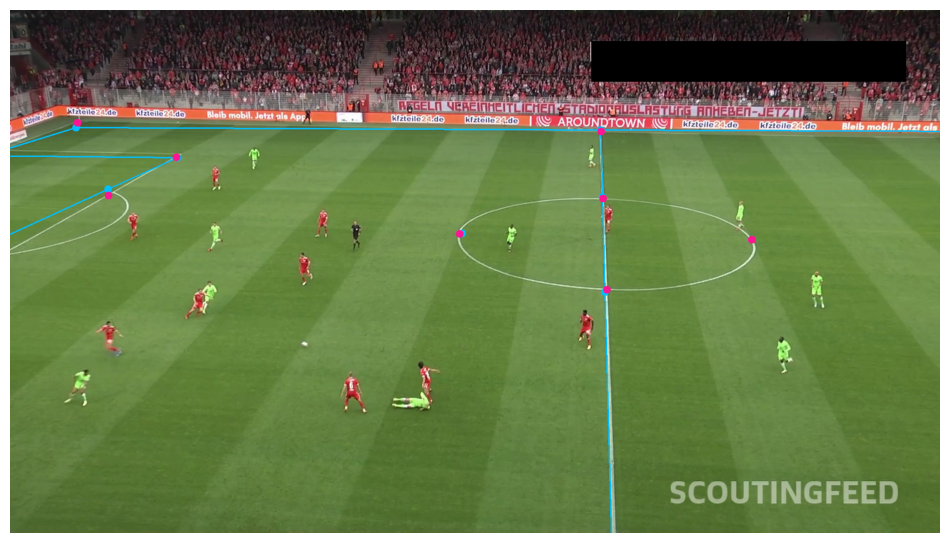

In [17]:
# Annotate pitch using field detection key points
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, 
    edges=CONFIG.edges
)
frame = next(sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200))

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(scene=annotated_frame, key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(scene=annotated_frame, key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(scene=annotated_frame, key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## Video Processing

Processing video frames for detection, homography transformation, and final video output.

In [ ]:
# Process video: detection video output
tracker = sv.ByteTrack()
tracker.reset()
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink = sv.VideoSink(TARGET_VIDEO_PATH, video_info=video_info)

with video_sink:
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
        video_sink.write_frame(frame_annotation(frame, f)[0])
print('Video Made.')

In [18]:
def interpolate_ball_positions(ball_positions) -> List[np.ndarray]:
    df_ball_positions = pd.DataFrame(ball_positions, columns=['x1','y1','x2','y2'])
    df_ball_positions = df_ball_positions.interpolate()
    df_ball_positions = df_ball_positions.bfill()
    ball_positions = df_ball_positions.to_numpy().tolist()
    return ball_positions


def replace_outliers_based_on_distance(positions: List[np.ndarray], distance_threshold: float) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions


def get_ball_positions(record):
    ball_positions = []
    num_frames = len(record)
    for i, frame_info in enumerate(record):
        detections = frame_info['frameDetections'].detections
        ball_detections = detections[detections.class_id == BALL_ID]
        index = 0
        if len(ball_detections) == 0:
            ball_positions.append(ball_detections.xyxy)
            continue
        elif len(ball_detections) > 1:
            xy = ball_detections.get_anchors_coordinates(sv.Position.CENTER)
            neighbor_positions = []
            start = max(0, i - 5)
            end = min(num_frames, i + 6)
            for j in range(start, end):
                if j == i:
                    continue 
                neighbor_frame = record[j]
                neighbor_detections = neighbor_frame['frameDetections'].detections
                neighbor_ball_detections = neighbor_detections[neighbor_detections.class_id == BALL_ID]
                if len(neighbor_ball_detections) > 0:
                    neighbor_xy = neighbor_ball_detections.get_anchors_coordinates(sv.Position.CENTER)
                    if neighbor_xy.ndim > 1 and neighbor_xy.shape[0] > 1:
                        neighbor_xy = np.mean(neighbor_xy, axis=0)
                    neighbor_positions.append(neighbor_xy)
            if neighbor_positions:
                centroid = np.mean(np.array(neighbor_positions), axis=0)
                distances = np.linalg.norm(xy - centroid, axis=1)
                index = np.argmin(distances)     
        ball_positions.append(ball_detections.xyxy[index])
    return ball_positions

In [ ]:
CONFIG = SoccerPitchConfiguration()

pitch_frame = draw_pitch(CONFIG)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
video_sink1 = sv.VideoSink("/kaggle/working/offside.mp4", video_info=video_info)
video_sink2 = sv.VideoSink("/kaggle/working/vornoi.mp4", video_info=video_info)

frame_height, frame_width = pitch_frame.shape[:2]
video_writer1 = cv2.VideoWriter('/kaggle/working/offside_pitch.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
video_writer2 = cv2.VideoWriter('/kaggle/working/heatmap.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
video_writer3 = cv2.VideoWriter('/kaggle/working/heatmap2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

tracker = sv.ByteTrack()
tracker.reset()
record = []
record2 = []  
previous_possesion = None
frame_number = 0
team0possesion = 0
team1possesion = 0
team0passes = 0
team1passes = 0

start_time = time.time()
# Generating a record of every frame and saving it.
for frame in tqdm(frame_generator, total=video_info.total_frames):
    result = DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)
    f = FrameDetections(frame=frame, detections=detections, tracker=tracker, team_classifier=team_classifier)
    p = PitchDetections(frame, f, key_points=key_points)
    frame_info = {
        'frame': frame_number,
        'frameDetections': f,
        'pitchDetections': p
    }
    record.append(frame_info)
    frame_number += 1

# Cleaning up the ball positions.
player_history = []
ball_positions = get_ball_positions(record)
cleaned_positions = replace_outliers_based_on_distance(ball_positions, 500)
interpolated_positions = interpolate_ball_positions(cleaned_positions)


# Saving those positions in the record.
for frame_info, ball_position in zip(record, interpolated_positions):
    detections = frame_info['frameDetections'].detections
    ball_detections = detections[detections.class_id == BALL_ID]
    other_detections = detections[detections.class_id != BALL_ID]
    if len(ball_detections)==0 or len(ball_detections)>1:
        detections = sv.Detections(
            xyxy=np.vstack([other_detections.xyxy, ball_position]),
            confidence=np.hstack([other_detections.confidence, [0.7]]),
            class_id=np.hstack([other_detections.class_id, [BALL_ID]]),
            data={'class_name': np.hstack([other_detections.data['class_name'], ['Ball']])}
        )
        frame_info['frameDetections'].detections = detections
        frame_info['frameDetections'].ball_detections = detections[detections.class_id == BALL_ID]
        frame_info['frameDetections'].ball_detections.xyxy = sv.pad_boxes(xyxy=frame_info['frameDetections'].ball_detections.xyxy, px=10)

# Dictionaries to keep track of player positions and distances
last_positions = {}       
cumulative_distances = {} 
x_scale = 105 / 12000  
y_scale = 68 / 7000    
instantaneous_speed = {}


for frame_idx, frame_info in enumerate(record):
    if frame_idx % 5 == 0:
        pitch_det = frame_info['pitchDetections']
        for tracker_id, pos in zip(frame_info['frameDetections'].all_players_detections.tracker_id, pitch_det.pitch_all_players_xy):
            current_pos = np.array(pos)
            if tracker_id in last_positions:
                last_pos = last_positions[tracker_id]
                current_pos_m = np.array([current_pos[0] * x_scale, current_pos[1] * y_scale])
                last_pos_m = np.array([last_pos[0] * x_scale, last_pos[1] * y_scale])
                dist = np.linalg.norm(current_pos_m - last_pos_m)
                cumulative_distances[tracker_id] = cumulative_distances.get(tracker_id, 0) + dist
                dt = 5 / fps
                speed_m_s = dist / dt
                speed_km_h = speed_m_s * 3.6
                instantaneous_speed[tracker_id] = speed_km_h
            else:
                instantaneous_speed[tracker_id] = 0
            last_positions[tracker_id] = current_pos
    frame_info['cumulative_distances'] = cumulative_distances.copy()
    frame_info['instantaneous_speed'] = instantaneous_speed.copy()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
previous_possesion_frame_number = 0

with video_sink1, video_sink2:
    for idx, (frame, frame_info) in enumerate(tqdm(zip(frame_generator, record), total=video_info.total_frames)):
        f = frame_info['frameDetections']
        p = frame_info['pitchDetections']
        frame_number = frame_info['frame']

        last_defender_positions, potential_offsides = find_last_defender(f, p)
        output, possesion = frame_annotation(frame, f, 
                                           offside=True, 
                                           last_defender_positions=last_defender_positions, 
                                           potential_offsides=potential_offsides,  
                                           previous_possesion=previous_possesion, 
                                           cumulative_distances=frame_info['cumulative_distances'],
                                           instantaneous_speed=frame_info['instantaneous_speed'])
        if possesion is not None:
            if possesion.tracker_id in potential_offsides:
                prev_frame_info = record2[(frame_number-previous_possesion_frame_number)]
                if possesion.tracker_id in prev_frame_info['potential_offsides'] and prev_frame_info['player'].class_id==possesion.tracker_id:
                    print('OFFSIDE! Frame Number: '+str(prev_frame_info['frame']))
            if possesion.class_id == 0:
                team0possesion += 1
                if previous_possesion is not None:
                    if previous_possesion.class_id == 0:
                        team0passes += 1
            else:
                team1possesion += 1
                if previous_possesion is not None:
                    if previous_possesion.class_id == 1:
                        team1passes += 1
            previous_possesion = possesion
            previous_possesion_frame_number = frame_number
        frame_info2 = {
            'frame': frame_number,
            'player': possesion,
            'potential_offsides': potential_offsides
        }
        record2.append(frame_info2)
        voronoi_diagram = compute_voronoi(p)
        voronoi_frame = draw_pitch_heatmap_on_frame(voronoi_diagram, p.transformer_inverse, frame)
        annotated_frame = draw_pitch(CONFIG)
        annotated_frame = draw_pitch_voronoi_diagram(
            config=CONFIG,
            team_1_xy=p.pitch_players_xy[f.players_detections.class_id == 0],
            team_2_xy=p.pitch_players_xy[f.players_detections.class_id == 1],
            team_1_color=sv.Color.from_hex('00BFFF'),
            team_2_color=sv.Color.from_hex('FF1493'),
            pitch=annotated_frame
        )
        video_sink1.write_frame(output)
        video_sink2.write_frame(voronoi_frame)
        video_writer1.write(homography_pitch(frame, f, p, offside=True, last_defender_positions=last_defender_positions, potential_offsides=potential_offsides))
        video_writer2.write(annotated_frame)
        video_writer3.write(voronoi_diagram)
video_writer1.release()
video_writer2.release()
video_writer3.release()

print("--- %s seconds ---" % (time.time() - start_time))
print('---PASSES:---')
print('Team 0: '+str(team0passes))
print('Team 1: '+str(team1passes))
print('---POSSESSION:---')
print('Team 0: '+str(team0possesion*100/(team0possesion+team1possesion)))
print('Team 1: '+str(team1possesion*100/(team0possesion+team1possesion)))

 49%|████▊     | 364/750 [02:20<02:24,  2.66it/s]